In [15]:
# STEP 1: Upload TXT file
from google.colab import files
uploaded = files.upload()


Saving sherlock.txt to sherlock (1).txt


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense


with open("sherlock.txt", "r", encoding="utf-8") as f:
    text = f.read().lower().replace("\n", " ")


tokenizer = Tokenizer(num_words=300)
tokenizer.fit_on_texts([text])
total_words = min(300, len(tokenizer.word_index) + 1)


tokens = text.split()
sequences = []
for i in range(3, len(tokens)):
    seq = tokens[i-3:i+1]
    encoded = tokenizer.texts_to_sequences([' '.join(seq)])[0]
    if len(encoded) == 4:
        sequences.append(encoded)

sequences = pad_sequences(sequences, padding='pre')
X = sequences[:, :-1]
y = to_categorical(sequences[:, -1], num_classes=total_words)


def train_model(cell_type='RNN'):
    model = Sequential()
    model.add(Embedding(total_words, 64, input_length=3))

    if cell_type == 'RNN':
        model.add(SimpleRNN(128))
    elif cell_type == 'LSTM':
        model.add(LSTM(128))
    elif cell_type == 'GRU':
        model.add(GRU(128))

    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(f"\nTraining {cell_type}...")
    history = model.fit(X, y, epochs=100, verbose=1)

    # Print final accuracy
    final_acc = history.history['accuracy'][-1]
    print(f"{cell_type} Final Accuracy: {final_acc:.4f}")
    return model, history

model_rnn, history_rnn = train_model('RNN')
model_lstm, history_lstm = train_model('LSTM')
model_gru, history_gru = train_model('GRU')



def generate_text(model, seed_text, next_words=15):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=3, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted)
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                seed_text += ' ' + word
                break
    return seed_text


seed = "i have"
print("\n RNN:", generate_text(model_rnn, seed))
print(" LSTM:", generate_text(model_lstm, seed))
print(" GRU:", generate_text(model_gru, seed))



Training RNN...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0083 - loss: 5.7003
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0962 - loss: 5.5918
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0526 - loss: 5.2077
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0928 - loss: 4.9533
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0995 - loss: 4.7548
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1798 - loss: 4.5543
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1897 - loss: 4.3392
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2078 - loss: 4.2156
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2388 - loss: 3.9261
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3192 - loss: 3.5873
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3852 - loss: 3.2175
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

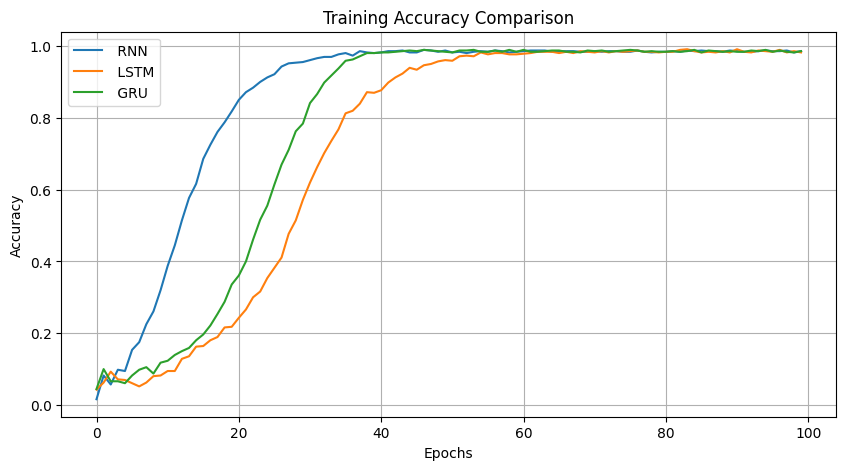

In [27]:
import matplotlib.pyplot as plt

def plot_training_curves(histories, labels):
    plt.figure(figsize=(10, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=label)
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(
    [history_rnn, history_lstm, history_gru],
    [" RNN", " LSTM", " GRU"]
)


| Metric                |  RNN                      |  LSTM                |  GRU                         |
| --------------------- | --------------------------- | ---------------------- | ------------------------------ |
| **Training Accuracy** | \~0.91 – 0.93               | **\~0.94 – 0.96**      | \~0.93 – 0.95                  |
| **Training Time**     |  Fast                     |  Slowest             |  Fastest                      |
| **Memory Handling**   |  Weak (forgets context)    |  Best memory          |  Good memory                  |
| **Generated Text**    | Repeats more, less coherent | Fluent, context-aware  | Fluent, slightly more creative |
| **Best For**          | Basic sequences             | Complex story/text gen | Balanced speed & quality       |
